In [2]:
import pandas as pd 

df = pd.read_csv("C:\\Users\\Eli\\Desktop\\news_dataset.csv", index_col=0)

In [3]:
#drop NaN values
df = df.dropna()
#reset index column after removing NaN values
df.reset_index(drop=True, inplace= True)
df 

,title,content,publication,label
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup,fake
...,...,...,...,...
27980,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,real
27981,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,real
27982,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,real
27983,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,real


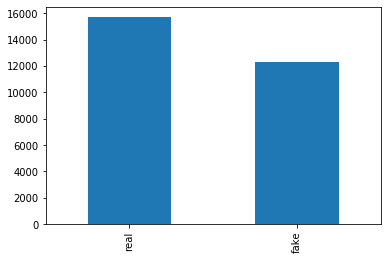

In [4]:
df['label'].value_counts().plot(kind='bar')

In [6]:
#text preprocessing imports
import nltk
import string

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

In [7]:
#Remove HTML data after the text was scraped 
def remove_html(text):
    soup = BeautifulSoup(text)
    html_free = soup.get_text()
    return html_free

In [8]:
#remove punctuation that we dont want to have tokenized
def remove_punctuation(text):
    no_punctuation = "".join([c for c in text if c not in string.punctuation])
    return no_punctuation

In [9]:
#tokenize each row using regex tokenizer, creating a list of words at every white space '\w' 
tokenizer = RegexpTokenizer(r'\w+')

In [10]:
#remove stopwords such as 'this' and 'in' as these would be the most common words when extracting features 
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [11]:
stemmer = PorterStemmer()

In [12]:
#normalize each word by removing the commoner morphological and inflexional endings
def word_stemmer(text):
    stem_text = " ".join([stemmer.stem(i) for i in text])
    return stem_text 

In [13]:
#group all the functions into one function call that we can use on individual paragraphs later and to preprocess the dataset
def preprocess_text(x):
    x = remove_html(x)
    x = remove_punctuation(x)
    x = tokenizer.tokenize(x.lower())
    x = remove_stopwords(x)
    x = word_stemmer(x)
    return x

In [ ]:
#preprocess the entire 'content' column
df['content'] = df['content'].apply(lambda x: preprocess_text(x))

In [ ]:
#checking to see if it worked on the entire dataframe
df['content']

In [ ]:
#save the processed dataset onto a new file for later use.
df.to_csv("C:\\Users\\Eli\\Desktop\\processed_news_dataset.csv")

In [47]:
df = pd.read_csv("C:\\Users\\Eli\\Desktop\\processed_news_dataset.csv", index_col=0)
df = df.dropna()
#reset index column after removing NaN values
df.reset_index(drop=True, inplace= True)
df 

,title,content,publication,label
0,Muslims BUSTED: They Stole Millions In Gov’t B...,print pay back money plu interest entir famili...,100percentfedup,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,attorney gener loretta lynch plead fifth barra...,100percentfedup,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,red state fox news sunday report morn anthoni ...,100percentfedup,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,email kayla mueller prison tortur isi chanc re...,100percentfedup,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,email healthcar reform make america great sinc...,100percentfedup,fake
...,...,...,...,...
27870,An eavesdropping Uber driver saved his 16-year...,uber driver keith avila pick passeng look like...,Washington Post,real
27871,Plane carrying six people returning from a Cav...,crew friday continu search lake eri plane carr...,Washington Post,real
27872,After helping a fraction of homeowners expecte...,obama administr announc massiv effort help dis...,Washington Post,real
27873,"Yes, this is real: Michigan just banned bannin...",stori updat new law michigan prohibit local go...,Washington Post,real


In [48]:
def collect_predictions(y_test,y_preds):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[y_test[idx]],pred] for idx,pred in enumerate(y_preds)]
    return pred_gold_list
    
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_vals=item[0]
        pred_vals=set(item[1])
        
        for label in true_vals:
            if label in pred_vals:
                correct+=1
                break

    accuracy=correct/float(len(eval_items))
    #print(correct, total)
    return accuracy

In [80]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from xgboost import XGBClassifier

import numpy as np
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    logging.info("Extracting features and vectorizing...")
    
    if "counts" in type:
        
        # count vectorizer
        cv= CountVectorizer(binary=False, max_df=0.90, min_df=0.01)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF vectorizer
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

def get_label_prediction(model,X_test):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probabilities = model.predict_proba(X_test)

    # get best fitting label
    best_n = np.argsort(probabilities, axis=1)[:,-1:]
    
    # get label prediction
    predictions=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    
    predictions=[ item[::-1] for item in predictions]
    
    return predictions
   
# train/test split
training_data, testing_data = train_test_split(df,random_state = 42,)

# get labels from the 'label' column
y_train=training_data['label'].values
y_test=testing_data['label'].values
     

def train_model_lr(df,field="content",feature_rep="counts"):
    
    logging.info("Initiating...")
    

    # get features
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)
    # start linear regression
    logging.info("Fitting Logistical Regression Model...")
    lr = LogisticRegression(solver='saga',random_state=42, C=5, penalty='l2',max_iter=5000)
    model=lr.fit(X_train,y_train)

    # get prediction
    prediction=get_label_prediction(model,X_test)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_predictions(y_test,prediction)
    
    # get accuracy values
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model,feature_transformer,accuracy

def train_model_nb(df,field, feature_rep):
    """Train a naive bayes model"""
    logging.info("Initiating...")
    
    # extract features 
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    # start naive bayes model
    logging.info("Fitting Naive Bayes Model...")
    nb = MultinomialNB()
    model_nb=nb.fit(X_train,y_train)

    # get prediction
    prediction=get_label_prediction(model_nb,X_test)
    
    # turn predicted items and ground truths into a list
    eval_items=collect_predictions(y_test,prediction)
    
    # get accuracy values
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model_nb,feature_transformer,accuracy

def train_model_xgb(df,field, feature_rep):
    """Train a naive bayes model"""
    logging.info("Initiating...")

    # extract features 
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    # start naive bayes model
    logging.info("Fitting Naive Bayes Model...")
    nb = MultinomialNB()
    model_nb=nb.fit(X_train,y_train)

    # get prediction
    prediction=get_label_prediction(model_nb,X_test)
    
    # turn predicted items and ground truths into a list
    eval_items=collect_predictions(y_test,prediction)
    
    # get accuracy values
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model_nb,feature_transformer,accuracy

In [76]:
#Training Logistic regression model using tfidf vectorizer
model_tfidf_lr,transformer_tfidf_lr,accuracy_tfidf_lr=train_model_lr(df,'content','tfidf')
print("\nAccuracy={0}".format(accuracy_tfidf_lr))

2020-03-31 01:28:55,153 : INFO : Initiating...
2020-03-31 01:28:55,154 : INFO : Extracting features and vectorizing...
2020-03-31 01:29:09,935 : INFO : Fitting Logistical Regression Model...
2020-03-31 01:29:12,436 : INFO : Starting evaluation...
2020-03-31 01:29:12,439 : INFO : Done training and evaluation.


6559 0

Accuracy=0.9411680298464629


In [81]:
#Training Logistic regression model using counts vectorizer
model_counts_lr,transformer_counts_lr,accuracy_counts_lr=train_model_lr(df,'content','counts')
print("\nAccuracy={0}".format(accuracy_counts_lr))

2020-03-31 01:31:29,152 : INFO : Initiating...
2020-03-31 01:31:29,152 : INFO : Extracting features and vectorizing...
2020-03-31 01:31:42,794 : INFO : Fitting Logistical Regression Model...
2020-03-31 01:34:44,515 : INFO : Starting evaluation...
2020-03-31 01:34:44,518 : INFO : Done training and evaluation.


6388 0

Accuracy=0.916630793514134


In [78]:
#Training Naive Bayes model using tfidf vectorizer
model_tfidf_nb,transformer_tfidf_nb,accuracy_tfidf_nb=train_model_nb(df,'content','tfidf')
print("\nAccuracy={0}".format(accuracy_tfidf_nb))

2020-03-31 01:30:05,531 : INFO : Initiating...
2020-03-31 01:30:05,532 : INFO : Extracting features and vectorizing...
2020-03-31 01:30:20,102 : INFO : Fitting Naive Bayes Model...
2020-03-31 01:30:20,304 : INFO : Starting evaluation...
2020-03-31 01:30:20,307 : INFO : Done training and evaluation.


4694 0

Accuracy=0.6735543119529345


In [79]:
#Training Naive Bayes model using counts vectorizer
model_counts_nb,transformer_counts_nb,accuracy_counts_nb=train_model_nb(df,'content','counts')
print("\nAccuracy={0}".format(accuracy_counts_nb))


2020-03-31 01:30:20,332 : INFO : Initiating...
2020-03-31 01:30:20,333 : INFO : Extracting features and vectorizing...
2020-03-31 01:30:33,800 : INFO : Fitting Naive Bayes Model...
2020-03-31 01:30:33,866 : INFO : Starting evaluation...
2020-03-31 01:30:33,869 : INFO : Done training and evaluation.


5840 0

Accuracy=0.8379968431625772


In [72]:
test_features=transformer_tfidf_lr.transform([preprocess_text('''Donald Trump said Monday that US officials expect the number of coronavirus cases in the United States to "spike" around Easter Sunday, a reversal from his talk of opening much of the country by 12 April.

The president, during a morning call-in interview with Fox News, continued his focus on the American death toll, saying this: "By a little short of June, maybe June 1m, we think ... the death will be ... brought down to a very low number."

Despite revising his own timeline for the virus spread subsiding on US soil, Mr Trump claimed the country is "getting close" to "winning" what he again called a "war" against the COVID-19 disease outbreak.

That came as his top infectious disease expert, Anthony Fauci, was back on television saying there could be up to 100,000 deaths from the virus inside the United States.

"We have a very low morality rate," Mr Trump said. "And there are reasons for that."

He contended that had his administration not taken certain steps, like banning travellers from China, 2.2m Americans could have died. (The US death toll now is over 2,000.) 

Read more

Dr Fauci warns ‘100,000 to 200,000’ people could die from coronavirus

'Be prepared for another cycle': Fauci warns coronavirus will return

The fascinating dynamic between Trump, Anthony Fauci and Deborah Birx

Coronavirus: Fauci emerges to defend relationship with Trump

Meet the man leading America’s fight against coronavirus
Two days after he floated a quarantine and strict travel restrictions for New York City, and parts of New Jersey and Connecticut, the president knocked down a question about closing airports to help stop the virus's spread. "We're looking at opening things up before closing" down more public gathering spaces. Without explaining, he said closing things like airports would be too difficult, suggesting the economic hit would be too high.

A day after Speaker Nancy Pelosi called Mr Trump's early response to warnings the virus was headed to the United States "deadly," the president called the California Democrat a "sick puppy."

"She's got a lot of problems, in my opinion," he said without providing details of those alleged issues. "There's something wrong with the woman."

The president then slammed San Francisco, where Ms Pelosi lives, calling it a "slum" and saying the federal government might take control of the region to address its alleged problems.

Trump calls Pelosi a 'sick puppy' for attacking him
The president appeared in full campaign mode as he cannot hold his signature rallies, contending "Sleepy Joe wouldn't even know what was going on." That was a dig at former Vice President Joe Biden, the presumptive Democratic presidential nominee whom Mr Trump contends is mentally feeble.

The "Fox & Friends" co-hosts were in campaign mode, as well, asking Mr Trump about high approval ratings for New York Governor Andrew Cuomo over his handling of the virus outbreak there. The president responded that Mr Cuomo has only been able to respond to the outbreak in the manner he has because of federal help that he green-lit. He also said he would "love" to run against the New York governor in a presidential general election.

In yet another stunning moment of his term, Mr Trump appeared to claim the United States should have a more confrontational relationship with Germany and a closer one with Russia because the then-Soviet Union lost "50 million people" fighting on the side of the United States – against then-Nazi Germany. "No one talks about that," he said, leaving out the US-Soviet Cold War that followed that world war.

He told the conservative news network's morning show he would be speaking to Russian President Vladimir Putin following the "Fox & Friends" interview. Mr Trump has been criticised for at times appearing to carry out Mr Putin's whims, even though his administration has put sanctions on Russians over its 2016 election meddling.''')])
get_label_prediction(model_tfidf_lr,test_features)


[['real']]

In [ ]:
test_features=transformer_counts_lr.transform([preprocess_text('''Writing in the Mail today, he warmed up by blasting Wonder Woman star Gal Gadot for her much-criticised, "tone deaf" version of Imagine that was supposed to lift people's spirits but left many cringing.

But he soon moved on to weightier targets, saying 47-year-old Idris had a place on his "idiot" list despite having contracted coronavirus himself - because he exposed the fact that A-listers were getting tested while NHS staff couldn't.

Piers later attacked High School Musical's Vanessa Hudgens, who called the virus a "bunch of bulls**t", saying she was in "urgent need of shutting the f*** up".

His ire then turned on singer Sam Smith, who earned a place on Piers' list thanks to a series of pictures they shared of a "meltdown" in self-isolation .''')])
get_label_prediction(model_counts_lr,test_features)

In [ ]:
test_features=transformer_tfidf_nb.transform([preprocess_text('''Writing in the Mail today, he warmed up by blasting Wonder Woman star Gal Gadot for her much-criticised, "tone deaf" version of Imagine that was supposed to lift people's spirits but left many cringing.

But he soon moved on to weightier targets, saying 47-year-old Idris had a place on his "idiot" list despite having contracted coronavirus himself - because he exposed the fact that A-listers were getting tested while NHS staff couldn't.

Piers later attacked High School Musical's Vanessa Hudgens, who called the virus a "bunch of bulls**t", saying she was in "urgent need of shutting the f*** up".

His ire then turned on singer Sam Smith, who earned a place on Piers' list thanks to a series of pictures they shared of a "meltdown" in self-isolation .''')])
get_label_prediction(model_tfidf_nb,test_features)


In [73]:
import pickle

model_path="C:\\Users\\Eli\\Documents\\GitHub\\fake-news-detection\\models\\model_tfidf_nb.pkl"
transformer_path="C:\\Users\\Eli\\Documents\\GitHub\\fake-news-detection\\models\\transformer_tfidf_nb.pkl"

# we need to save both the transformer -> to encode a document and the model itself to make predictions based on the weight vectors 
pickle.dump(model_tfidf_lr,open(model_path, 'wb'))
pickle.dump(transformer_tfidf_lr,open(transformer_path,'wb'))
